In [1]:
# import the libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")

In [16]:
def rsi(value, neutral, window):
	"""
	Input:
	:param value: (type dataframe pandas): Entry values of the stock
	:param neutral:(float) Value of the neutrality, i.e No Action Zone
	:param window: (float) rolling period for RSI calculation

	Output: The function gives the returns of RSI strategy
	:return:
	"""
	# Print error is no Adj Close column is not present
	if "Adj Close" not in value.columns:
		ValueError("Error: No Adj Close column is present")

	value['rsi'] = ta.momentum.RSIIndicator(value['Adj Close'], window=window).rsi()

	"""Long Buy signal"""
	overbuy = 70
	neutral_buy = 50 + neutral

	# Put nan values for te signal long columns
	value['signal_long'] = np.nan
	value['yesterday_rsi'] = value['rsi'].shift(1)
	# We need to define open long signal (Rsi yes>55 and RSI today>55)
	value.loc[(value['rsi'] > neutral_buy) & (value['yesterday_rsi'] < neutral_buy), 'signal_long'] = 1
	# open long signal for false positive (Rsi yes>55 and RSI today<55)
	value.loc[(value['rsi'] < neutral_buy) & (value['yesterday_rsi'] > neutral_buy), 'signal_long'] = 0
	# open long signal for overbuy (Rsi yes>70 and RSI today<70)
	value.loc[(value['rsi'] < overbuy) & (value['yesterday_rsi'] > overbuy), 'signal_long'] = 0

	"""Short Sell signal"""
	oversell = 30
	neutral_sell = 50 - neutral

	# Put the values for the short signal columns
	value['signal_short'] = np.nan
	value['yesterday_rsi'] = value["rsi"].shift(1)
	# We define the Open short signal (RSI yes>45 and RSI today<45)
	value.loc[(value['rsi'] < neutral_sell) & (value['yesterday_rsi'] > neutral_sell), 'signal_short'] = -1

	# We define the Close short signal(Rsi yes<45 and RSI today>45) False signal
	value.loc[(value['rsi'] > neutral_sell) & (value['yesterday_rsi'] < neutral_sell), 'signal_short'] = 0

	# We define the Close short signal (RSI yes<30 and RSI today>30) Oversell
	value.loc[(value['rsi'] > oversell) & (value['yesterday_rsi'] < oversell), 'signal_short'] = 0

	"""Compute the returns"""
	# Compute the percentage of the variation of the stock
	value['pct'] = value['Adj Close'].pct_change(1)

	# Calculate the position
	value['Position'] = (value['signal_short'].fillna(method='ffill') + value['signal_long'].fillna(method='ffill'))

	# Compute the returns
	value['return'] = value['pct'] * (value['Position'].shift(1))

	return value['return']

In [3]:
def beta_function(series):
	sp500 = yf.download('^GSPC')[['Adj Close']].pct_change(1)
	sp500.columns = ['SP500']

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1)

	# We compute the beta
	beta = np.cov(value[[series.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(value["SP500"].dropna().values)
	return beta

In [4]:
def drawdown_function(series):
	cumulative_sum = series.dropna().cumsum() + 1  # multiplication coefficient
	# compute the max of the cumulative_sum
	# (1,3,1,1,7,1,2,) -> (1,3,3,3,7,7,7)
	running_max = np.maximum.accumulate(cumulative_sum)
	drawdowned = cumulative_sum / running_max - 1
	return drawdowned

In [5]:
def backTest(series):
	# Import the Benchmark
	sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
	sp500.name = 'SP500'

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1).dropna()

	# compute the drawdown and max drawdown
	drawdown = drawdown_function(series)
	max_drawdown = -np.min(drawdown)

	"""Plot the Graph"""
	fig, (cum, draw) = plt.subplots(1, 2, figsize=(20, 6))
	fig.suptitle("Backtesting", size=20)

	cum.plot(series.cumsum(), color='#39B3C7')
	cum.plot(value['SP500'].cumsum(), color='#B85A0F')

	cum.legend(["Portfolio", "Benchmark(SP500)"])
	cum.set_title("Cumulative Returns", size=13)
	cum.set_ylabel("Cumulative Return in %", size=13)

	# Plot the drawdown
	draw.fill_between(drawdown.index, 0, drawdown * 100, color='#C73954', alpha=0.65)

	draw.set_title("Drawdown", size=15)
	draw.set_ylabel("Drawdown in %", size=13)

	# plot the graph
	plt.show()

	"""Compute the statistics"""
	# compute the sortino
	sortino = np.sqrt(252) * series.mean() / series.loc[series < 0].std()

	# compute the beta
	beta = np.cov(value[['return', 'SP500']].values, rowvar=False)[0][1] / np.var(value['SP500'].values)

	# compute the alpha
	alpha = 252 * (series.mean() - beta * series.mean())

	# Print the statistics

	print(f'Sortino: {np.round(sortino, 3)}')
	print(f'Beta: {np.round(beta, 3)}')
	print(f'Alpha: {np.round(alpha, 3)}')
	print(f'MaxDrawdown: {np.round( max_drawdown* 100, 3)}%')

[*********************100%***********************]  1 of 1 completed


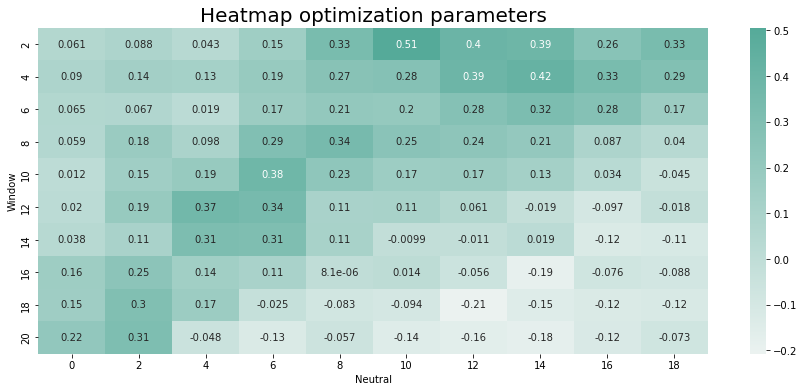

In [6]:
# Finding the best Hyper Parameter
# Heatmap of the best hyperparameter

data = yf.download('GOOG')

# set list for possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# set matrix with zeros
grid = np.zeros([len(neutral_values),len(window_values)])

# Calculate the return strategy for each combo
for i in range(len(neutral_values)):
	for j in range(len(window_values)):
		return_rsi = rsi(data,neutral_values[i],window_values[j])  # compute the return RSI
		grid[i][j] = np.sqrt(252) * return_rsi.mean() / (return_rsi[return_rsi<0].std() + 0.00001)

# Adapt the size
plt.figure(figsize=(15,6))

# Palette color for heatmap
palette = sns.color_palette("light:#5A9", as_cmap=True)

# Plot the map
sns.heatmap(grid,annot=True,xticklabels=neutral_values,yticklabels=window_values,cmap=palette)

plt.title("Heatmap optimization parameters", size=20)
plt.xlabel("Neutral")
plt.ylabel("Window")
plt.show()

In [7]:
def grid_param(data):
	# set list for possible values of neutral and window
	neutral_values = [i*2 for i in range(10)]
	window_values = [i*2 for i in range(1,11)]

	# set matrix with zeros
	grid = np.zeros([len(neutral_values),len(window_values)])

	# Calculate the return strategy for each combo
	for i in range(len(neutral_values)):
		for j in range(len(window_values)):
			return_rsi = rsi(data,neutral_values[i],window_values[j])  # compute the return RSI
			grid[i][j] = np.sqrt(252) * return_rsi.mean() / return_rsi[return_rsi<0].std()

	# return the grid
	return grid

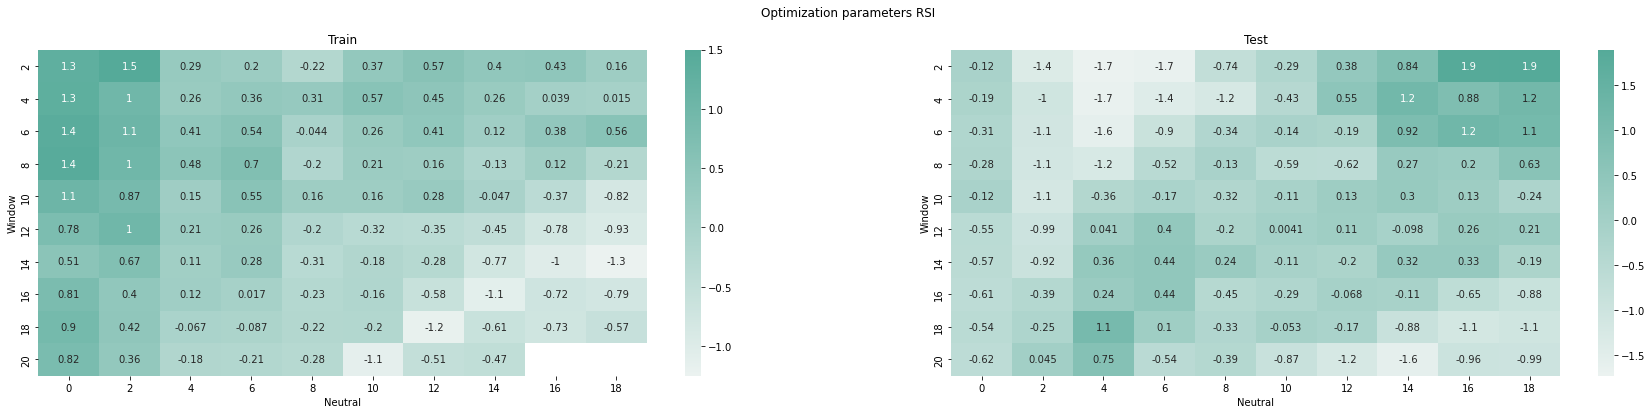

In [8]:
 # We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Train,test and validation data
start_train,end_train = "2017-01-01",'2019-01-01'
start_test,end_test = '2019-01-01','2020-01-01'
start_valid,end_valid = '2020-01-01','2021-01-01'

# Create the grid
grid_train = grid_param(data.loc[start_train:end_train])
grid_test = grid_param(data.loc[start_test:end_test])

# Create a subplots
fig, (train,test) = plt.subplots(1,2,figsize=(30,6))
fig.suptitle("Optimization parameters RSI")

# Change color
palette = sns.color_palette("light:#5A9", as_cmap=True)

# Train data heatmap and labeling
sns.heatmap(grid_train,annot=True,ax=train,xticklabels=neutral_values,yticklabels=window_values,cmap=palette)
train.set_title("Train")
train.set_xlabel("Neutral")
train.set_ylabel("Window")

# Test data heatmap and labeling
sns.heatmap(grid_test,annot=True,ax=test,xticklabels=neutral_values,yticklabels=window_values,cmap=palette)
test.set_title("Test")
test.set_xlabel("Neutral")
test.set_ylabel("Window")

# Show the plot
plt.show()

[*********************100%***********************]  1 of 1 completed


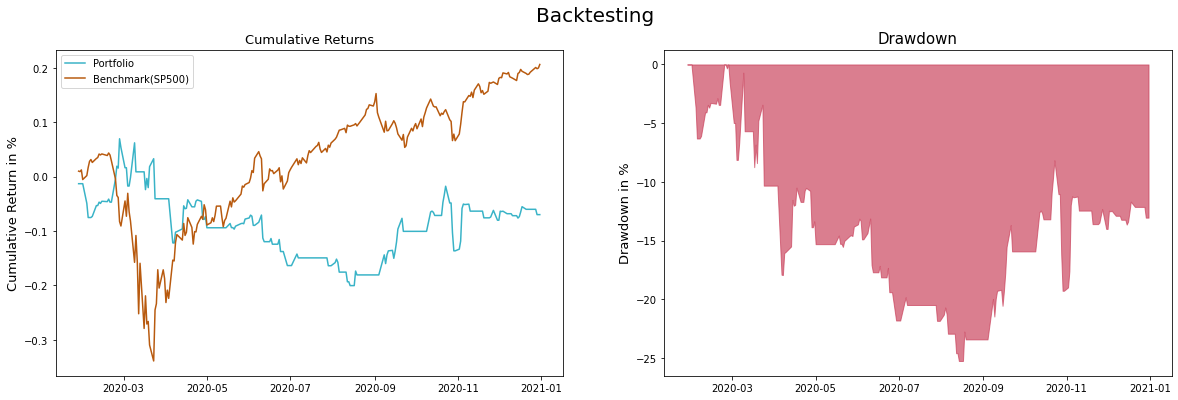

Sortino: -0.265
Beta: -0.212
Alpha: -0.09
MaxDrawdown: 25.245%


In [9]:
backTest(rsi(data.loc[start_valid:end_valid],8,6))

In [10]:
# Statistical approach for Parameter
# We list for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Set some dataset
start_train,end_train = "2017-01-01",'2019-01-01'
start_test,end_test = '2019-01-01','2020-01-01'
start_valid,end_valid = '2020-01-01','2021-01-01'

# Initialize the list
result = []

for i in range(len(neutral_values)):
	for j in range(len(window_values)):
		# Compute the return
		return_train = rsi(data.loc[start_train:end_train],neutral_values[i],window_values[j])
		return_test = rsi(data.loc[start_test:end_test],neutral_values[i],window_values[j])

		# Compute the sortino
		sortino_train = np.sqrt(252) * return_train.mean() / (return_train[return_train<0].std() + 0.00001)
		sortino_test = np.sqrt(252) * return_test.mean() / (return_test[return_test<0].std() + 0.00001)

		values = [neutral_values[i],window_values[j],sortino_train,sortino_test]
		result.append(values)

dataframe = pd.DataFrame(result,columns=["Neutral","Window","Sortino_train","Sortino_test"])

In [11]:
ordered_data = dataframe.sort_values(by=["Sortino_train"],ascending=False)
for i in range(len(dataframe)):
	# Take the best
	best = ordered_data.iloc[0+i:1+i,:]

	# Extract the sortino
	sortino_train = best["Sortino_train"].values[0]
	sortino_test = best["Sortino_test"].values[0]

	# Take best neutral and window
	best_neutral = best["Neutral"].values[0]
	best_window = best["Window"].values[0]

	# If the best is found, we stop the loop
	if sortino_test > 0.5 and sortino_train > 0.5:
		break
	else:
		best_neutral = 0
		best_window = 0
		sortino_train = 0
		sortino_test = 0

[*********************100%***********************]  1 of 1 completed


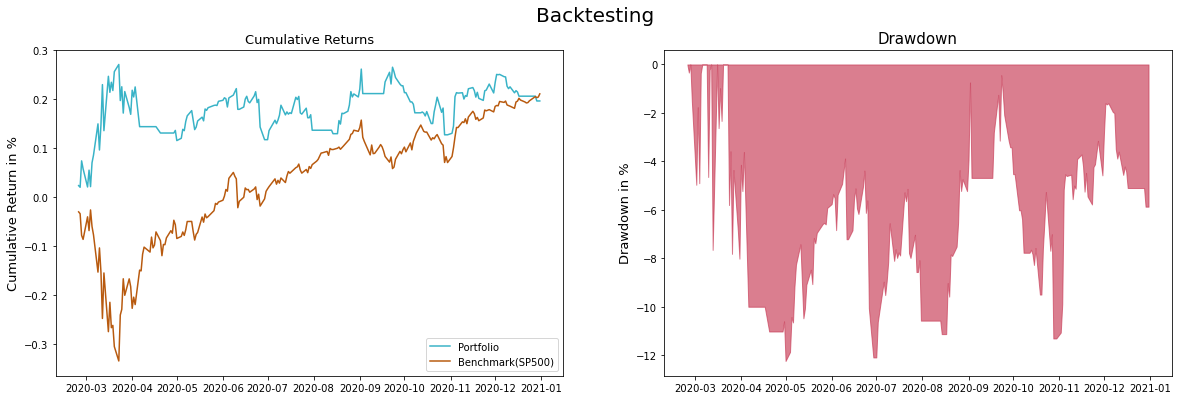

Sortino: 0.739
Beta: -0.508
Alpha: 0.343
MaxDrawdown: 12.228%


In [12]:
backTest(rsi(data.loc[start_valid:end_valid],best_neutral,best_window))

In [13]:
def optimization(data):
	# Statistical approach for Parameter
	# We list for the possible values of neutral and window
	neutral_values = [i*2 for i in range(10)]
	window_values = [i*2 for i in range(1,11)]

	# Set some dataset
	start_train,end_train = "2017-01-01",'2019-01-01'
	start_test,end_test = '2019-01-01','2020-01-01'
	start_valid,end_valid = '2020-01-01','2021-01-01'

	# Initialize the list
	result = []

	for i in range(len(neutral_values)):
		for j in range(len(window_values)):
			# Compute the return
			return_train = rsi(data.loc[start_train:end_train],neutral_values[i],window_values[j])
			return_test = rsi(data.loc[start_test:end_test],neutral_values[i],window_values[j])

			# Compute the sortino
			sortino_train = np.sqrt(252) * return_train.mean() / (return_train[return_train<0].std() + 0.00001)
			sortino_test = np.sqrt(252) * return_test.mean() / (return_test[return_test<0].std() + 0.00001)

			values = [neutral_values[i],window_values[j],sortino_train,sortino_test]
			result.append(values)

	dataframe = pd.DataFrame(result,columns=["Neutral","Window","Sortino_train","Sortino_test"])
	ordered_data = dataframe.sort_values(by=["Sortino_train"],ascending=False)
	for i in range(len(dataframe)):
		# Take the best
		best = ordered_data.iloc[0+i:1+i,:]

		# Extract the sortino
		sortino_train = best["Sortino_train"].values[0]
		sortino_test = best["Sortino_test"].values[0]

		# Take best neutral and window
		best_neutral = best["Neutral"].values[0]
		best_window = best["Window"].values[0]

		# If the best is found, we stop the loop
		if sortino_test > 0.5 and sortino_train > 0.5:
			break
		else:
			best_neutral = 0
			best_window = 0
			sortino_train = 0
			sortino_test = 0
	return [best_neutral,best_window,sortino_train,sortino_test]

In [17]:
data = yf.download("GOOG")
optimization(data.dropna())

[*********************100%***********************]  1 of 1 completed


[4, 20, 0.5599837510917088, 1.109685156468514]

[*********************100%***********************]  1 of 1 completed


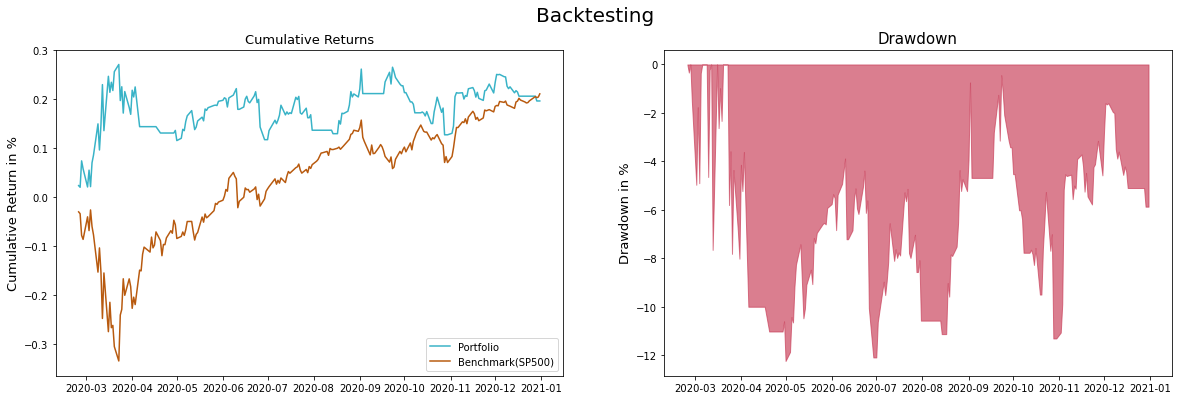

Sortino: 0.739
Beta: -0.508
Alpha: 0.343
MaxDrawdown: 12.228%


In [18]:
backTest(rsi(data.loc[start_valid:end_valid],best_neutral,best_window))